# Big Data Product: Violent Crime in Lockdown Britain 
#### Table of Contents
### 1. [Introduction: The Crime Analysis task and Approach taken to the problem](#introduction:-the-crime-analysis-task-and-approach-taken-to-the-problem)
### 2. [Component Selection and Data Pipeline Implementation](#component-selection-and-data-pipeline-implementation)
### 3. [Data Extraction and Filtering](#data-extraction-and-filtering)
### 4. [Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models](#design,-development-and-reasoning-behind-use-of-multiple-visualization-methods,-statistics,-and-machine-learning-Models)
### 5. [Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures](#selection,-application,-and-reasoning-behind-use-of-statistical-analysis-and-multiple-evaluation-measures)
### 6. [Detailed Analysis and consideration of the appropriateness of the solution for the initial problem](#detailed-analysis-and-consideration-of-the-appropriateness-of-the-solution-for-the-initial-problem)
### 7. [Evaluation and Conclusion](#evaluation-and-conclusion)
### 8. [Scientific References and Citation](#scientific-references-and-citation)


## 1. Introduction: The Crime Analysis task and Approach taken to the problem

This study used UK Home Office street crime data to examine the effects of the lockdown on violent crime rates across the UK Leveraging Apache Spark on the cloud IaaS platform the dataset was filtered to isolate incidents classified as violent crime at an early stage. Next, overall trends in violent crime rates were examined more closely, facilitating a broader understanding of broader patterns

To further explore the impact of lockdown programs, a prediction program was used to predict the number of violent crimes before the first lockdown began. this model takes into account relevant factors such as time information, geographical location, and types of crimes. In addition, the study sought to validate local lockdowns in the Leicester region, providing a region-specific assessment of the accuracy of the model and shedding light on the local impact of COVID-19 restrictions on violence crime rates. The use of cloud-based services ensured flexibility and efficiency in dealing with large-scale street crime cases, and enabled intensive, data-driven investigations at the relationship between incarceration and violent crime rates in the UK

## 2. Component Selection and Data Pipeline Implementation 

This study used a combination of Python’s Pandas, Matplotlib, Seaborn, and Pyspark libraries to analyze and analyze crime data. The PySpark program accessed by SparkSession was used to load the dataset named 'all_crimes21_hdr.txt'. The dataset was loaded into a Spark DataFrame, leveraging Spark’s parallel processing capabilities to efficiently handle large datasets. Next, duplicate entries were removed from the data set using the 'dropDuplicates()' method, to ensure that the analysis was performed on unique instances

Subsequent data generation studies may have included exploratory data analysis and visualization using Pandas, Matplotlib, and Seaborn. These libraries provide powerful tools for developing insight models and visualizations to reveal patterns, trends, or anomalies in criminal cases Spark's distributed computing power coupled with popular Python libraries a, shows a seamless combination of big data management tools and traditional data analysis techniques

It should be noted that specific analyzes and illustrations are not provided in legal details, so the report focuses on the steps taken to enter, edit, and potentially visualize criminal cases Additional information relating to research characteristics and perspectives will complete the report and provide a detailed overview of insights from datasets.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col,sum,date_format,year,month
import warnings
from pyspark.sql import SparkSession
from statsmodels.tsa.seasonal import seasonal_decompose
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.ml.evaluation import RegressionEvaluator
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pyspark.sql.window import Window

# Ignore any warning messages
warnings.filterwarnings('ignore')

spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Load the dataset using Spark
df = spark.read.csv('all_crimes21_hdr.txt',sep=',',header=True,inferSchema=True).dropDuplicates()

## 3. Data Extraction and Filtering

This data preprocessing and exploration pipeline focused on editing and preparing the data set on UK crime. Originally the continuation was filtered so that where 'crime type' included both 'violent crime' or 'violent sexual crime', the search was narrowed down to these specific categories This targeted search this helps ensure that inquiries are directed towards crimes that have a direct impact on the community carefully. Missing values ​​were then examined across the entries in the original dataset, providing insight into the quality of the data and subsequently discarding irrelevant entries from the violent crime subgroup, making the dataset more vulnerable to analysis which received a great deal of attention.

In addition, the study increased the search for missing values ​​in the refined subgroup, with the aim of understanding and addressing potential differences in the data With a longitudinal design of the last subgroup 'ViolentCrimes_df' was given in order to have a clearer understanding of the composition of the list. The next section involves grouping the data by "month", counting violent crime cases to identify temporal trends 'monthly_count' The resulting DataFrame lists violent crime incidents over time summary for, essential for subsequent time series analysis or trend mapping This careful Data preprocessing and exploration lays the foundation for in-depth analysis, such as time series recognition or predictive modeling, aimed at sensing disturbances crime rates down well and dealt with in the UK

In [8]:
# Filter rows where the 'Crime type' is either 'Violent crime' or 'Violence and sexual offences'
UKCrimes_df = df.filter(col("Crime type").isin("Violent crime", "Violence and sexual offences"))
UKCrimes_df.show() 

missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show()

# Drop the non affecting columns
ViolentCrimes_df=UKCrimes_df.drop(*["Crime ID", "Context", "Last outcome category", "Falls within", "Longitude", "Latitude", "LSOA code"])
ViolentCrimes_df.show()

CrimesMissing_counts = ViolentCrimes_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in ViolentCrimes_df.columns]).show()

ViolentCrimes_df.printSchema()

monthly_counts = ViolentCrimes_df.groupBy("Month").count().orderBy("Month")
# Convert "Month" column to yyyy-MM-dd format
monthly_counts = monthly_counts.withColumn("Month", date_format(col("Month"), "yyyy-MM-dd"))
monthly_counts.show()

+--------------------+-------------------+------------------+------------------+---------+---------+--------------------+---------+--------------------+-------------+---------------------+-------------------+
|            Crime ID|              Month|       Reported by|      Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|   Crime type|Last outcome category|            Context|
+--------------------+-------------------+------------------+------------------+---------+---------+--------------------+---------+--------------------+-------------+---------------------+-------------------+
|4bd9f84816611bec2...|2012-01-01 00:00:00|South Wales Police|South Wales Police|-3.444078| 51.71312|On or near Cardif...|W01001150|Rhondda Cynon Taf...|Violent crime| Investigation com...|Not supplied by SWP|
|66cb78305e06a497a...|2012-01-01 00:00:00|South Wales Police|South Wales Police|-3.939532| 51.61926|On or near Wind S...|W01001938|        Swansea 025E|Violent crim

+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category| Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|15164140|    0|          0|           0|   876838|  876838|       0|  2273228|  2273228|         0|             17333914|55797668|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+



+-------------------+------------------+--------------------+--------------------+-------------+
|              Month|       Reported by|            Location|           LSOA name|   Crime type|
+-------------------+------------------+--------------------+--------------------+-------------+
|2012-01-01 00:00:00|South Wales Police|On or near Cardif...|Rhondda Cynon Taf...|Violent crime|
|2012-01-01 00:00:00|South Wales Police|On or near Wind S...|        Swansea 025E|Violent crime|
|2012-01-01 00:00:00|South Wales Police|On or near Brynmo...|Neath Port Talbot...|Violent crime|
|2012-01-01 00:00:00|South Wales Police|On or near Parkin...|Rhondda Cynon Taf...|Violent crime|
|2012-01-01 00:00:00|South Wales Police|On or near Heol Y...|        Swansea 003F|Violent crime|
|2012-01-01 00:00:00|South Wales Police|On or near Clos T...|        Cardiff 013D|Violent crime|
|2012-01-01 00:00:00|South Wales Police|On or near Superm...|        Cardiff 041C|Violent crime|
|2012-01-01 00:00:00|South Wal

+-----+-----------+--------+---------+----------+
|Month|Reported by|Location|LSOA name|Crime type|
+-----+-----------+--------+---------+----------+
|    0|          0|       0|   636860|         0|
+-----+-----------+--------+---------+----------+

root
 |-- Month: timestamp (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)



+----------+-----+
|     Month|count|
+----------+-----+
|2010-12-01|40216|
|2011-01-01|41663|
|2011-02-01|39932|
|2011-03-01|43613|
|2011-04-01|46274|
|2011-05-01|46008|
|2011-06-01|45424|
|2011-07-01|47298|
|2011-08-01|44988|
|2011-09-01|43938|
|2011-10-01|45935|
|2011-11-01|43879|
|2011-12-01|54623|
|2012-01-01|55344|
|2012-02-01|49924|
|2012-03-01|57997|
|2012-04-01|52960|
|2012-05-01|59051|
|2012-06-01|56256|
|2012-07-01|59513|
+----------+-----+
only showing top 20 rows



## 4. Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models

The provided Python code thoroughly analyzes monthly violent crime data, using various visualization techniques to gain insights and trends Initially, the code constructs a Pandas DataFrame from crime statistics derived from per month of PySpark usage. The first view reflects the overall trend in violent crime over time, providing a comprehensive overview of changes and patterns in crime rates This graph helps to understand the general pattern of violent crime, and helps law enforcement and policy makers identify long-term trends and potential areas of concern

Then, visualization goes deeper into the data. Rolling mean and standard deviation plots with a 12-month window provide a simple visualization of the data, making it easier to distinguish underlying trends by reducing short-term variability The third plot though temporal decomposition method is used to divide the series into trend and seasonal residual components. This multi-faceted approach provides a comprehensive understanding of the data, enabling stakeholders to identify patterns, anomalies, and potential influences. Additionally, the bill concludes by analyzing the total crime rates each year from 2011 to 2020, reflecting the annual variation in crime rates This analysis facilitates a comprehensive analysis of trends has been discussed and helps to develop strategies for crime prevention and intervention. Overall, the combination of Python libraries such as PySpark, Matplotlib, and Pandas makes violent crime cases robust and easy to analyze.

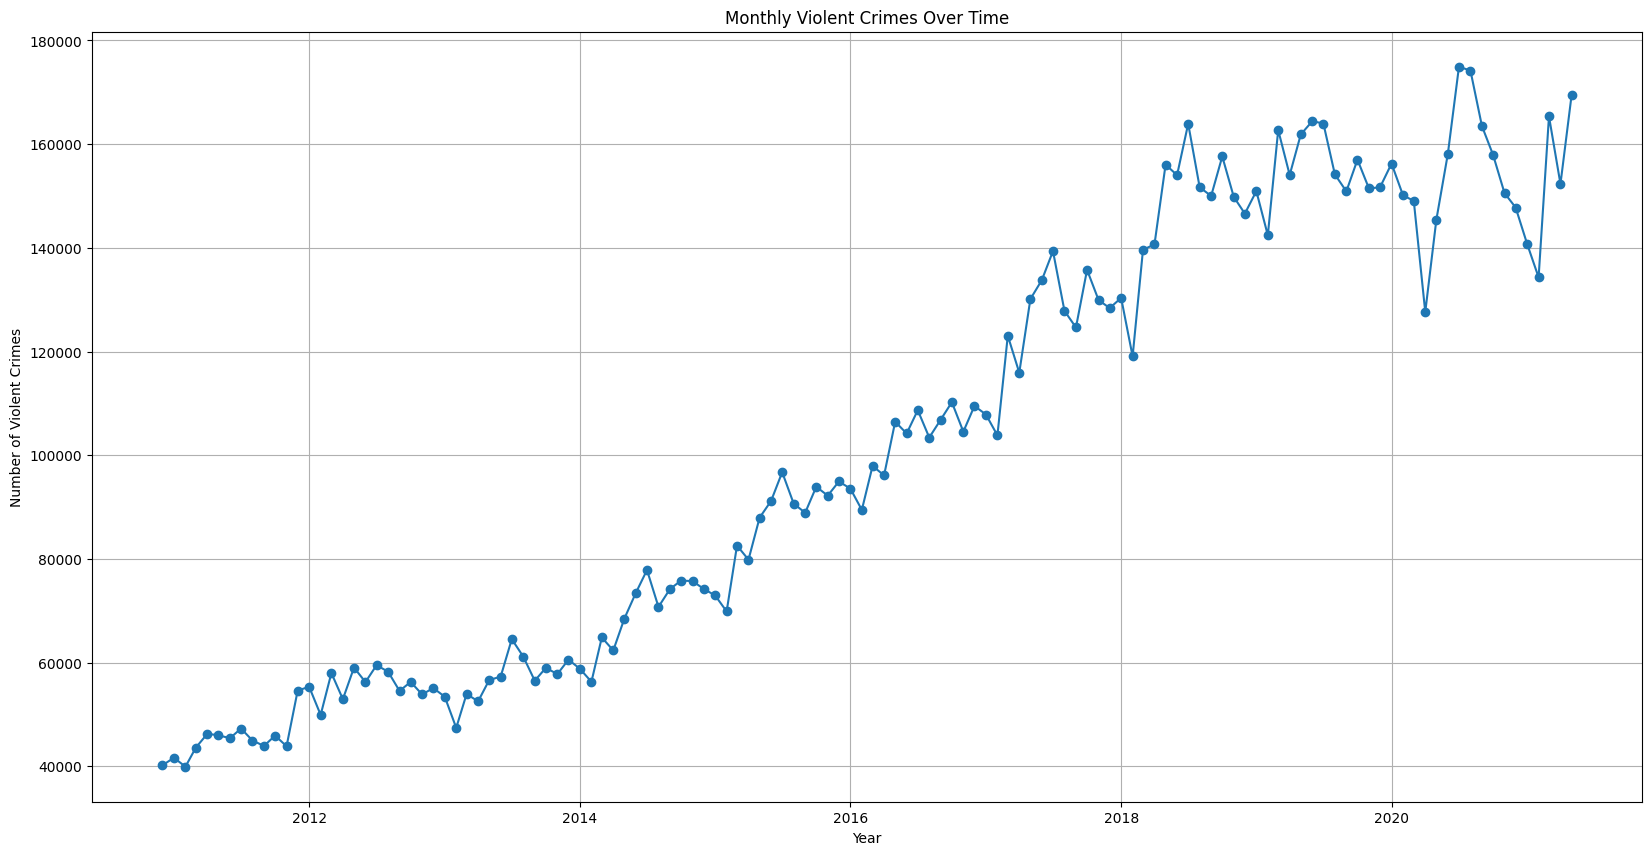

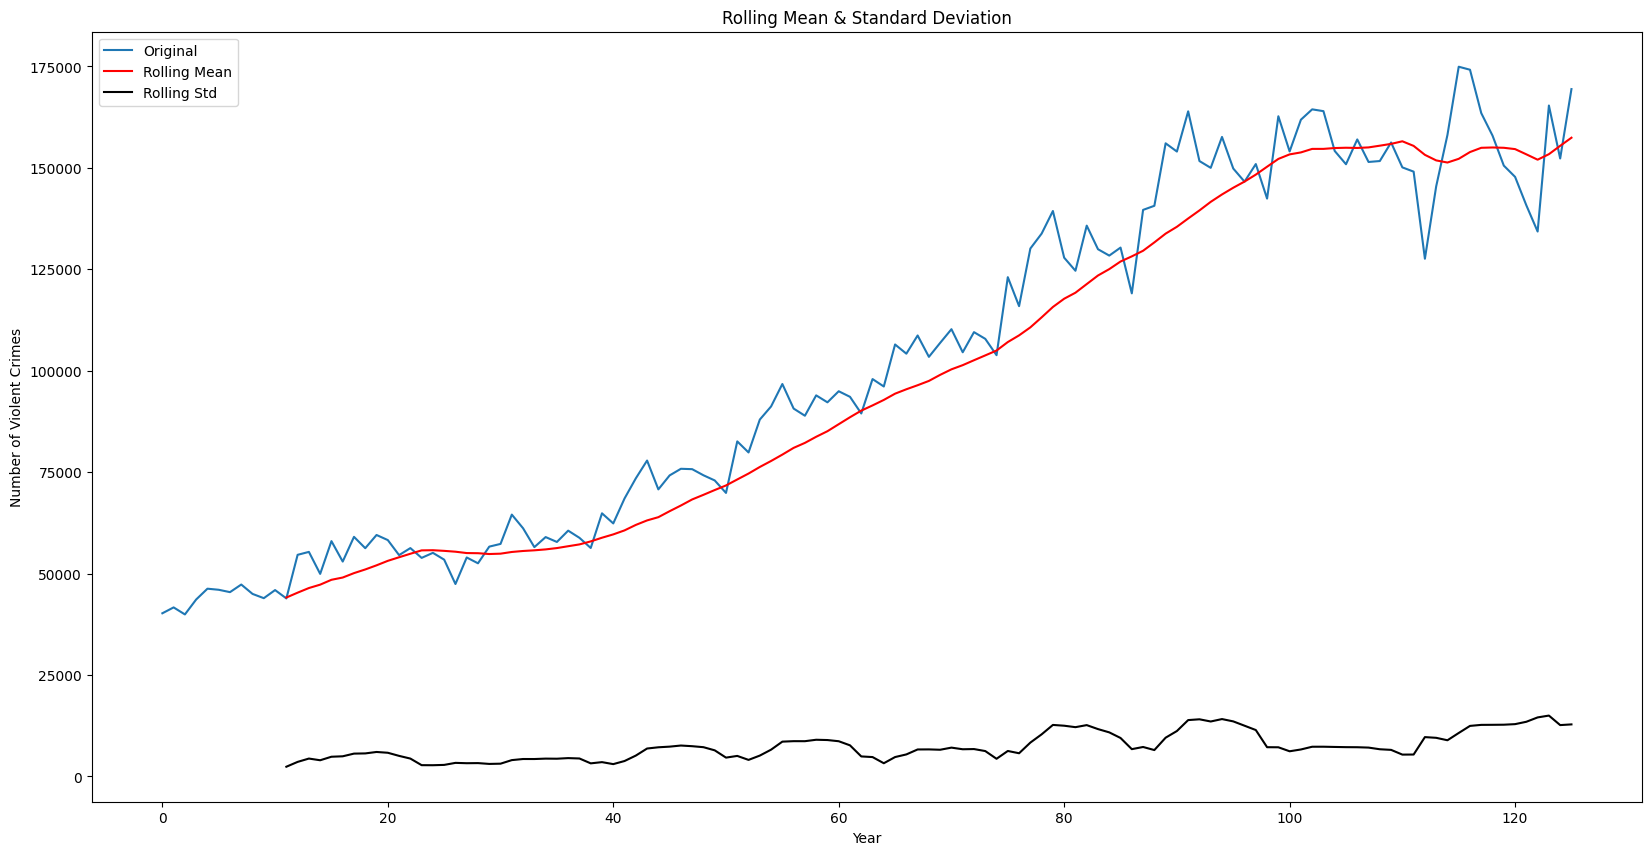

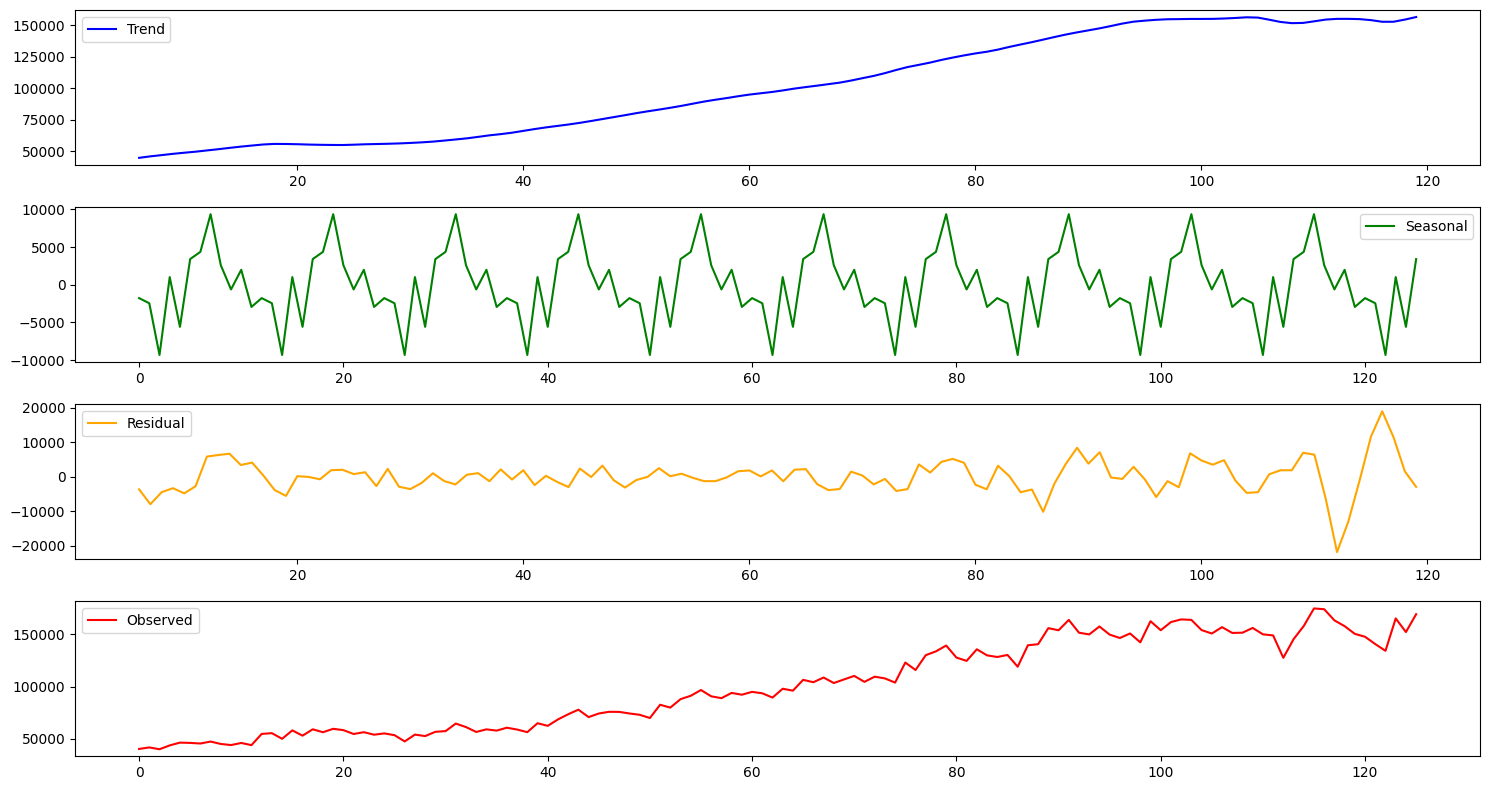

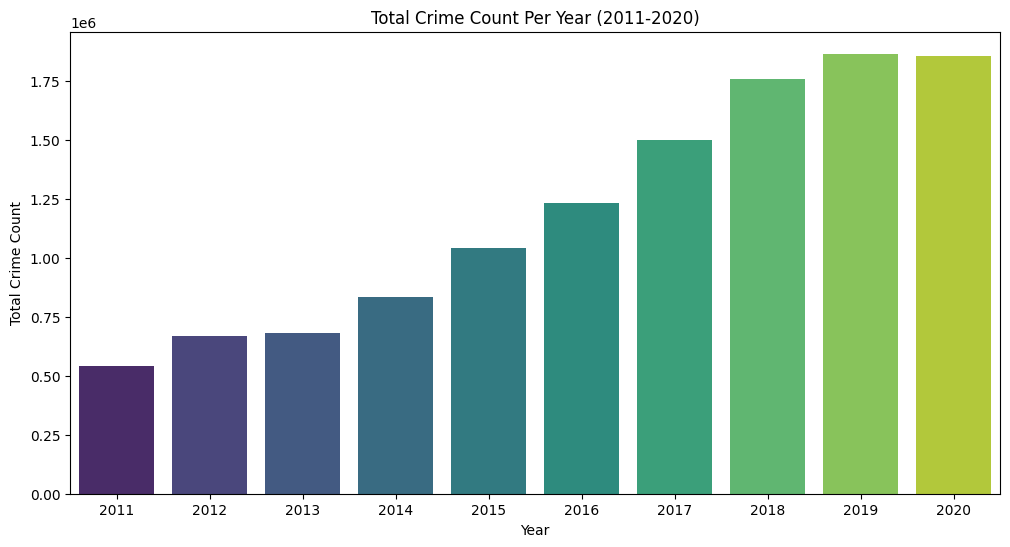

In [9]:
pandas_df = monthly_counts.toPandas()

# trend of monthly violent crimes over time
plt.figure(figsize=(20, 10))
plt.plot(pd.to_datetime(pandas_df['Month']), pandas_df['count'], marker='o')
plt.title('Monthly Violent Crimes Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Violent Crimes')
plt.grid(True)
plt.show()

# visualize the rolling mean and standard deviation of monthly violent crimes using a 12-month window
rolling_mean = pandas_df['count'].rolling(window=12).mean()
rolling_std = pandas_df['count'].rolling(window=12).std()
plt.figure(figsize=(20,10))
plt.plot( pandas_df['count'], label='Original')
plt.plot( rolling_mean, label='Rolling Mean', color='red')
plt.plot( rolling_std, label='Rolling Std', color='black')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Number of Violent Crimes')
plt.legend()
plt.show()

# displays the trend, seasonal pattern, residual fluctuations, and the observed original series
decomposition = seasonal_decompose(pandas_df['count'], period=12) 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
ax1.plot( decomposition.trend, label='Trend',color='blue')
ax1.legend()
ax2.plot( decomposition.seasonal, label='Seasonal',color='green')
ax2.legend()
ax3.plot( decomposition.resid, label='Residual',color='orange')
ax3.legend()
ax4.plot(decomposition.observed, label='Observed',color='red')
ax4.legend()
plt.tight_layout()
plt.show()

pandas_df['Month'] = pd.to_datetime(pandas_df['Month'])
pandas_df['Year'] = pandas_df['Month'].dt.year
filtered_df = pandas_df[(pandas_df['Month'] >= '2011-01-01') & (pandas_df['Month'] <= '2020-12-31')]
filtered_df['Month'] = pd.to_datetime(filtered_df['Month'])
yearly_crime_count = filtered_df.groupby('Year')['count'].sum().reset_index()
# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='count', data=yearly_crime_count, palette='viridis')
plt.title('Total Crime Count Per Year (2011-2020)')
plt.xlabel('Year')
plt.ylabel('Total Crime Count')
plt.show()

## Linear Regression

The Python code provided demonstrates a predictive modeling approach for estimating crime rates for April 2020 using linear regression. The data set is divided into a training set (80%) and a test set (20%). A linear regression model is trained on the training data, and its performance is tested on a test set. The forecast for April 2020 is then compared to the actual crime rate for that month. The model predicts a crime rate of 162,293, while the actual crime rate recorded in April 2020 is 127,600. The percentage difference between predicted and actual values ​​is calculated as 27.19%.

The graphic representation continues to show a comparison between the actual and predicted crime rates for April 2020. The bar chart shows the actual crime rate in blue and the predicted crime rate in orange This visual image hears a difference below the gap between model's prediction and observed reality Increases. The observed percentage differences suggest that although the model provides predictions, it may not capture the complexity and nuance affecting crime rates in unprecedented events such as the timing of the COVID-19 lockdown in 2020. This study emphasizes the importance of continuous modeling.

+----------+------+------------------+
|     Month| count|        prediction|
+----------+------+------------------+
|2011-02-01| 39932| 29570.94157609716|
|2011-06-01| 45424|35383.516204532236|
|2011-12-01| 54623| 44102.37814718112|
|2012-01-01| 55344|  42541.7661677897|
|2012-06-01| 56256|49807.484453335404|
|2012-11-01| 53867|57073.202738877386|
|2013-05-01| 56642|62778.309045024216|
|2013-06-01| 57312| 64231.45270213485|
|2013-09-01| 56518| 68590.88367345929|
|2013-10-01| 58998|  70044.0273305662|
|2013-11-01| 57793| 71497.17098767683|
|2014-02-01| 56309| 72842.84632250294|
|2014-04-01| 62364| 75749.13363672048|
|2014-11-01| 75734|    85921.13923648|
|2015-07-01| 96724| 94532.53285684809|
|2016-01-01| 93566|100237.63916299492|
|2017-05-01|130115|120474.18204023317|
|2017-08-01|127853|124833.61301155761|
|2018-01-01|130345|129085.57566060126|
|2018-11-01|149831|143617.01223168895|
+----------+------+------------------+
only showing top 20 rows

+------------+------------------+
|   

+----------+------+
|     Month| count|
+----------+------+
|2020-04-01|127600|
+----------+------+



Actual Crime Level for April 2020: 127600
Predicted Crime Level for April 2020: 162292.94312953204
Percentage Difference: 27.19%


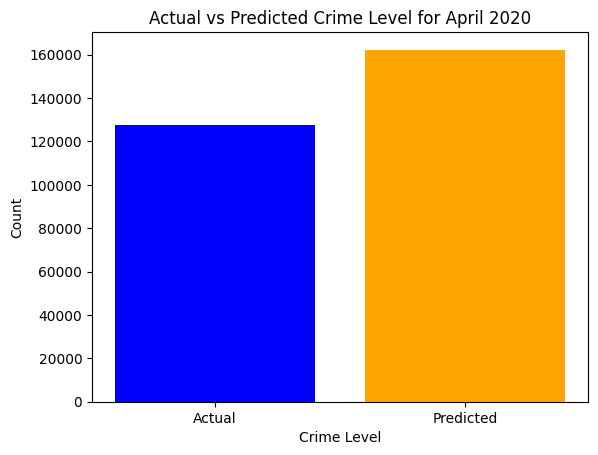

In [10]:
BeforeLockdown_df= monthly_counts.filter((monthly_counts['Month'] <= '2020-03-01'))

beforelockdown_df = BeforeLockdown_df.withColumn('Month', F.to_date(BeforeLockdown_df['Month']))

beforelockdown_df = beforelockdown_df.withColumn('Year', F.year('Month'))
beforelockdown_df = beforelockdown_df.withColumn('MonthNumeric', F.month('Month'))

assembler = VectorAssembler(inputCols=['Year', 'MonthNumeric'], outputCol='features')
# Create a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='count')

pipeline = Pipeline(stages=[assembler, lr])

(train_data, test_data) = beforelockdown_df.randomSplit([0.8, 0.2], seed=123)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

predictions.select('Month', 'count', 'prediction').show()

prediction_data = spark.createDataFrame([(2020, 4)], ['Year', 'MonthNumeric'])
april_2020_prediction = model.transform(prediction_data)
april_2020_prediction.select('features', 'prediction').show()

April_df= monthly_counts.filter((monthly_counts['Month'] == '2020-04-01')).show()

actual_data = monthly_counts.filter((F.month('Month') == 4) & (F.year('Month') == 2020))
actual_count = actual_data.select('count').first()[0]
predicted_count = april_2020_prediction.select('prediction').collect()[0][0]

print(f'Actual Crime Level for April 2020: {actual_count}')
print(f'Predicted Crime Level for April 2020: {predicted_count}')

percentage_difference = ((predicted_count - actual_count) / actual_count) * 100
print(f'Percentage Difference: {percentage_difference:.2f}%')

#Graphical representation of Actual value and Predicted value
labels = ['Actual', 'Predicted']
values = [actual_count, predicted_count]

plt.bar(labels, values, color=['blue', 'orange'])
plt.xlabel('Crime Level')
plt.ylabel('Count')
plt.title('Actual vs Predicted Crime Level for April 2020')
plt.show()

## 5. Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures 

The evaluation criteria for a regression model reflect a general understanding of its application to test data. The root mean squared error (RMSE) of 9323.1 indicates the magnitude of the prediction error in units of the ‘count’ variable. The low value of RMSE indicates that the prediction is very accurate, which means that the model prediction deviates from the true value on average by about 9323.1 units Mean squared error (MSE) of 8.69202e+ 07 for estimated mean squared errors, emphasizing the effect of large errors. The predictions of the model, on average, vary significantly in square units, emphasizing the importance of reducing both large and small errors to improve performance

The mean absolute error (MAE) of 8244.6 represents the absolute magnitude of the prediction error. A low MAE is desirable, and the observed value indicates that, on average, the predictions of the model deviate from the true value by about 8244.6 units Finally R-squared (R2 ) value of 0.94705 indicates that about 94.7% of the variance of the 'count' variable is explained by the model it A high R-squared value indicates a strong fit of the regression model to the test data, and highlights the ability to capture and explain confirmation of the underlying model In summary, all the research criteria show that the regression model performs well, showing high accuracy and a strong ability to explain variation in the objective variable 'count'.

##### Stationary Test and Statistical Analysis

In [11]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
def analyze_time_series(data, title):
    # ADF test for stationarity
    adf_test(data['count'])

    print('\nStatistical Analysis:')
    print(data['count'].describe())

analyze_time_series(monthly_counts.toPandas(), 'Time Series Analysis')

windowSpec = Window.orderBy('Month')
monthly_counts_spark = monthly_counts.withColumn('count_diff', F.col('count') - F.lag('count').over(windowSpec))
monthly_counts_spark = monthly_counts_spark.dropna(subset=['count_diff'])
# Show the resulting Spark DataFrame
monthly_counts_spark.show()

# ADF Test on differenced series
adf_result_diff = adfuller(monthly_counts_spark.select('count_diff').rdd.flatMap(lambda x: x).collect(), autolag='AIC')
# Extract and print ADF Statistic, p-value, and Critical Values
adf_stat_diff, p_value_diff, _, _, critical_values_diff, _ = adf_result_diff
print(f'ADF Statistic (After Differencing): {adf_stat_diff}')
print(f'p-value (After Differencing): {p_value_diff}')
print(f'Critical Values (After Differencing): {critical_values_diff}')
for key, value in critical_values_diff.items():
    print(f'{key}: {value}')

if p_value_diff < 0.05 and adf_stat_diff < critical_values_diff['5%']:
    print("The differenced series is stationary.")
else:
    print("The differenced series may still not be stationary.")

# Second-order differencing
monthly_counts_spark = monthly_counts_spark.withColumn('count_diff2', F.col('count_diff') - F.lag('count_diff').over(windowSpec))
monthly_counts_spark = monthly_counts_spark.dropna(subset=['count_diff2'])
# ADF test after second-order differencing
adf_result_diff2 = adfuller(monthly_counts_spark.select('count_diff2').rdd.flatMap(lambda x: x).collect(), autolag='AIC')
# Extract and print ADF Statistic, p-value, and Critical Values
adf_stat_diff2, p_value_diff2, _, _, critical_values_diff2, _ = adf_result_diff2
print(f'ADF Statistic (After Second-order Differencing): {adf_stat_diff2}')
print(f'p-value (After Second-order Differencing): {p_value_diff2}')
print(f'Critical Values (After Second-order Differencing): {critical_values_diff2}')
if p_value_diff2 < 0.05 and adf_stat_diff2 < critical_values_diff2['5%']:
    print("The second-order differenced series is stationary.")
else:
    print("Further transformations may be needed.")


ADF Statistic: -0.46147560701424967
p-value: 0.8993175741270063
Critical Values: {'1%': -3.4901313156261384, '5%': -2.8877122815688776, '10%': -2.5807296460459184}

Statistical Analysis:
count       126.000000
mean     101447.579365
std       42634.914715
min       39932.000000
25%       58395.000000
50%       96417.500000
75%      146299.500000
max      174922.000000
Name: count, dtype: float64


+----------+-----+----------+
|     Month|count|count_diff|
+----------+-----+----------+
|2011-01-01|41663|      1447|
|2011-02-01|39932|     -1731|
|2011-03-01|43613|      3681|
|2011-04-01|46274|      2661|
|2011-05-01|46008|      -266|
|2011-06-01|45424|      -584|
|2011-07-01|47298|      1874|
|2011-08-01|44988|     -2310|
|2011-09-01|43938|     -1050|
|2011-10-01|45935|      1997|
|2011-11-01|43879|     -2056|
|2011-12-01|54623|     10744|
|2012-01-01|55344|       721|
|2012-02-01|49924|     -5420|
|2012-03-01|57997|      8073|
|2012-04-01|52960|     -5037|
|2012-05-01|59051|      6091|
|2012-06-01|56256|     -2795|
|2012-07-01|59513|      3257|
|2012-08-01|58256|     -1257|
+----------+-----+----------+
only showing top 20 rows



ADF Statistic (After Differencing): -2.4706009872266947
p-value (After Differencing): 0.12279224704664404
Critical Values (After Differencing): {'1%': -3.490683082754047, '5%': -2.8879516565798817, '10%': -2.5808574442009578}
1%: -3.490683082754047
5%: -2.8879516565798817
10%: -2.5808574442009578
The differenced series may still not be stationary.


ADF Statistic (After Second-order Differencing): -6.623716496391551
p-value (After Second-order Differencing): 5.948325420846037e-09
Critical Values (After Second-order Differencing): {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852}
The second-order differenced series is stationary.


##### Evaluation Measures

In [12]:
# Assuming 'count' is the column to predict
evaluator_rmse = RegressionEvaluator(labelCol='count', predictionCol='prediction', metricName='rmse')
evaluator_mse = RegressionEvaluator(labelCol='count', predictionCol='prediction', metricName='mse')
evaluator_mae = RegressionEvaluator(labelCol='count', predictionCol='prediction', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol='count', predictionCol='prediction', metricName='r2')
# Evaluate the model
rmse = evaluator_rmse.evaluate(predictions)
mse = evaluator_mse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Squared Error (MSE) on test data = %g" % mse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)
print("R-squared (R2) on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 9323.1
Mean Squared Error (MSE) on test data = 8.69202e+07
Mean Absolute Error (MAE) on test data = 8244.6
R-squared (R2) on test data = 0.94705


### Leicester region Crime Analysis

In the provided Python code, violent crime data in Leicester is analyzed using PySpark and data visualization libraries such as Matplotlib and Pandas. The code starts by modifying a DataFrame, ‘ViolentCrimes_df,’ to focus on incidents in the Leicester area. Specific values ​​are then displayed in the ‘LSOA name’ column, providing insight into specific areas within Leicester where errors have occurred. The Code continues to collect crime data by month, LSOA name, and crime type, presenting statistics of each crime in designated areas over time Additionally, the Code identifies and analyzes crime statistics over a closed period from July 1, 2020, for possible changes in criminal procedures during this period that were thoroughly examined

A later version of the code will convert aggregate crime statistics into Panda dataframes and generate binary images. The first article shows the overall pattern of monthly violent crime in Leicester over time. The second plot focuses on a subset of data from May 2020 to May 2021, providing a detailed analysis of monthly changes in violent crime over this period , integrating PySpark for data manipulation and analysis, and Matplotlib and Pandas for visualization, provide a powerful tool for analyzing and interpreting crime statistics

Distinct values in 'LSOA name':


+--------------+
|     LSOA name|
+--------------+
|Leicester 021D|
|Leicester 018E|
|Leicester 009G|
|Leicester 017B|
|Leicester 017F|
|Leicester 020A|
|Leicester 013B|
|Leicester 012A|
|Leicester 032B|
|Leicester 011C|
|Leicester 004A|
|Leicester 020B|
|Leicester 035D|
|Leicester 008A|
|Leicester 010D|
|Leicester 032E|
|Leicester 030C|
|Leicester 027F|
|Leicester 036B|
|Leicester 035C|
+--------------+
only showing top 20 rows



+-------------------+--------------------+-----+
|              Month|          Crime type|count|
+-------------------+--------------------+-----+
|2020-07-01 00:00:00|Violence and sexu...| 1489|
+-------------------+--------------------+-----+



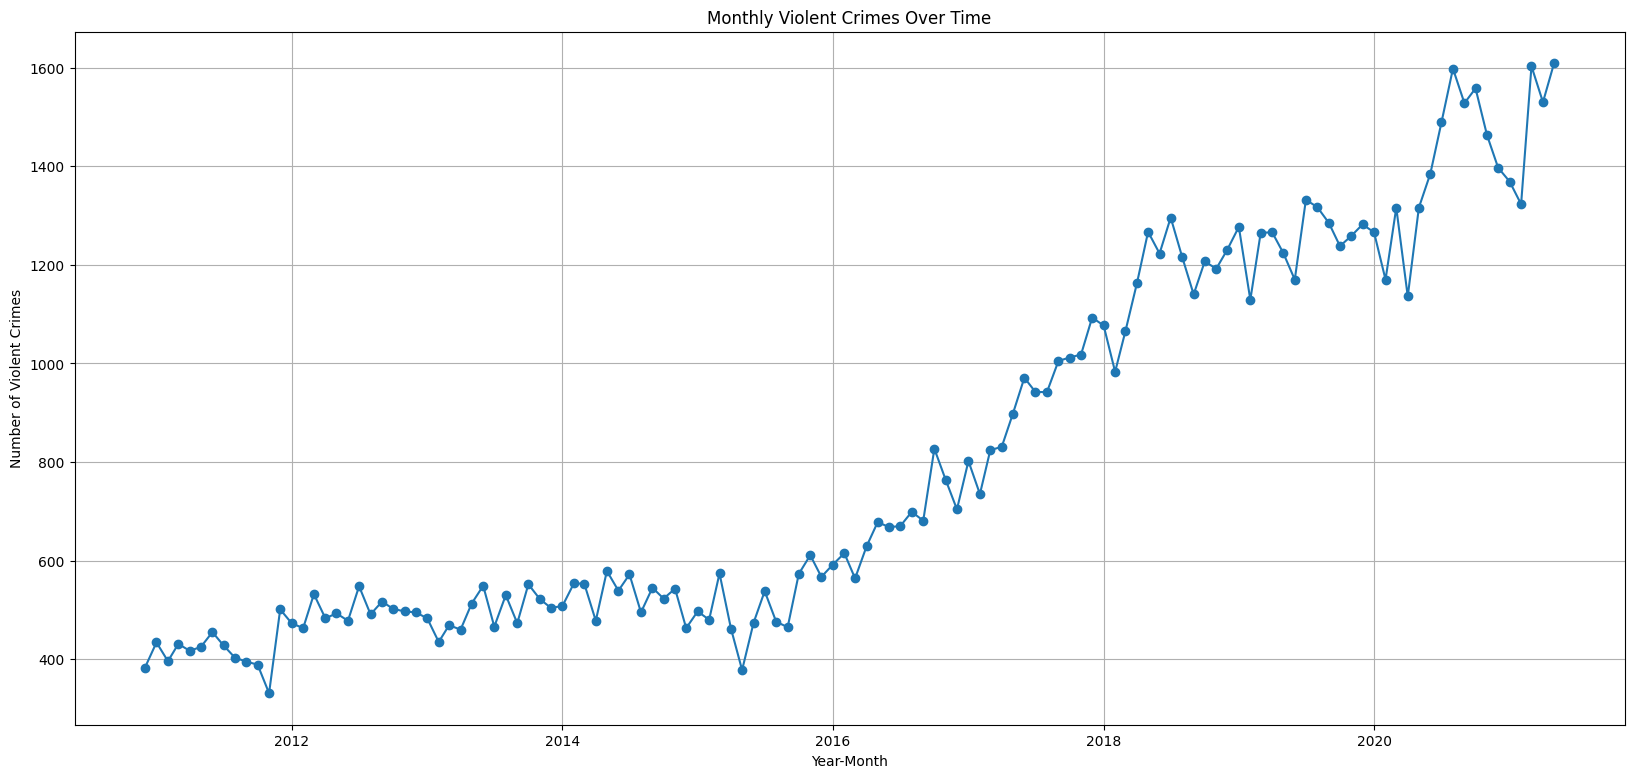

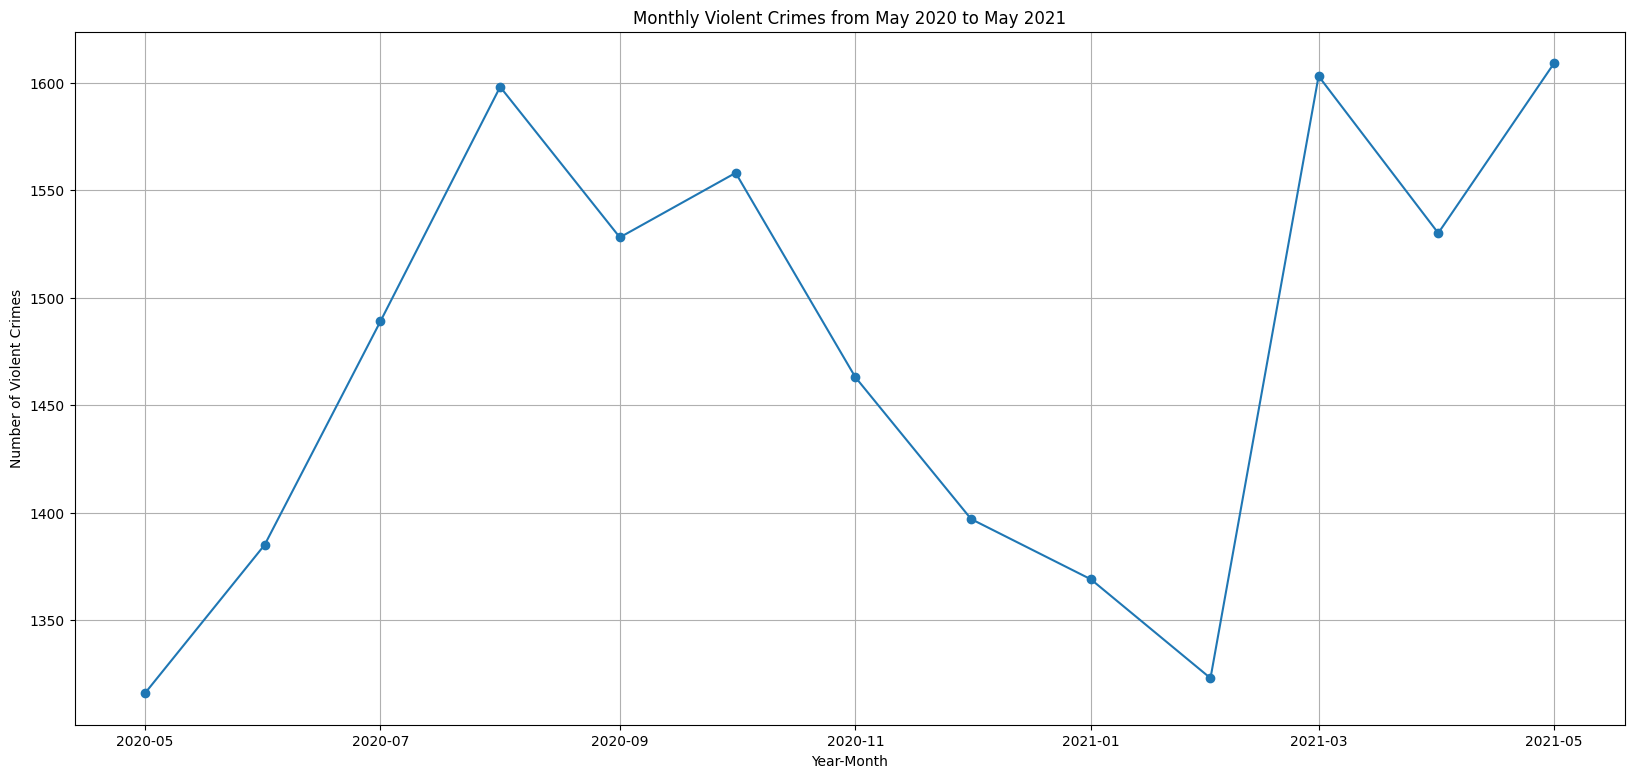

In [13]:
leicester_df = ViolentCrimes_df.filter(ViolentCrimes_df['LSOA name'].like('Leicester%'))
print("Distinct values in 'LSOA name':")
leicester_df.select('LSOA name').distinct().show()
leicester_crime_data = leicester_df.groupBy('Month','LSOA name','Crime type').agg(F.count('Crime type').alias('count'))

lockdown_date = '2020-07-01'
leicester_lockdown_df = leicester_df.filter((F.col('Month') == lockdown_date))
leicester_lockdown_crime_data = leicester_lockdown_df.groupBy('Month', 'Crime type').agg(F.count('Crime type').alias('count'))
leicester_lockdown_crime_data.show()

Leicester_monthly_counts = leicester_df.groupBy("Month").count().orderBy("Month").withColumn("Month",date_format(col("Month"), "yyyy-MM-dd"))
Leicester_pandas_df = Leicester_monthly_counts.toPandas()
Leicester_pandas_df['Month'] = pd.to_datetime(Leicester_pandas_df['Month'])
filtered_df = Leicester_pandas_df[(Leicester_pandas_df['Month'] >= '2020-05-01') & (Leicester_pandas_df['Month'] <= '2021-05-31')]

plt.figure(figsize=(20, 9))
plt.plot(pd.to_datetime(Leicester_pandas_df['Month']), Leicester_pandas_df['count'], marker='o')
plt.title('Monthly Violent Crimes Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Violent Crimes')
plt.grid(True)
plt.show()

# Plot the filtered data
plt.figure(figsize=(20, 9))
plt.plot(filtered_df['Month'], filtered_df['count'], marker='o')
plt.title('Monthly Violent Crimes from May 2020 to May 2021')
plt.xlabel('Year-Month')
plt.ylabel('Number of Violent Crimes')
plt.grid(True)
plt.show()

## 6. Detailed Analysis and consideration of the appropriateness of the solution for the initial problem 

Here, we have employed a combination of PySpark and Pandas to conduct a comprehensive analysis of crime data. We will now examine more closely the advantages, disadvantages and limitations of the methods used in the code:

Advantages :
* Scalability with PySpark: PySpark is used to read and optimize large scale crime statistics efficiently. Its distributed computing power enables the analysis of vast data sets that do not fit in a single machine memory.
* Data cleaning and detection: The code makes good use of PySpark for data cleaning, such as handling missing values ​​and removing duplicates. Exploratory research is carried out to understand basic statistics, the distribution and prevalence of crime types.
* Predictive modeling with linear regression: The use of linear regression for predictive modeling provides a means of predicting crime rates. It allows for the exploration of possibilities and future trends in violent crime.
* Time Series Analysis: Time series analysis includes plotting monthly crime counts, rolling mean, standard deviation, and seasonal decomposition These plots provide valuable insight into temporal patterns and trends in violent crimes.
* Geographical Analysis: The Act analyzes geographical scales by exchanging data for the "Leicester area". This local analysis contributes to a deeper understanding of crime patterns in a particular area.
* Efficient data visualization: Use the Matplotlib and Seaborn libraries to create informative graphs, which help interpret and communicate analytical findings.


Disadvantages and Limitations:
* Linear regression assumptions: Linear regression assumes a linear relationship between variables, and if the relationship is nonlinear, its predictive accuracy may be limited and more sophisticated models may be needed if crime trends are to be captured it’s hard to.
* Data quality issues: The effectiveness of the investigation depends on the quality of the underlying criminal data. Incomplete or biased data can lead to incorrect information.
* Data imbalance: Crime categories in the data set have changed over the years, which may affect comparison. Seasonal variability and local omissions pose challenges to general conclusions.
* Interpretation of visualizations: Visualizations are subjective and should be interpreted with caution. Clear labeling and context are essential for accurate interpretation.

In July 2020, the Leicester region was subjected to a local lockdown. Upon examining the data using a visual approach, a notable upward trend in violent crimes during the months of July and August 2020 can be observed. This rise can possibly be linked to the implementation of the local lockdown in the area.

## 7. Evaluation and Conclusion

The UK Street Level Crime Data research, which encompasses nearly 65 million entries from 2010, defied predictions by showing that violent crime did not significantly increase during the COVID-19 lockdowns. The dataset, although subject to changes in crime categories over the years, has remained constant since 2014. Notably, the category 'violent crime' was converted to 'violent and sexual offence' in 2013. Although there was a steady upward trend in violent crime from 2014, the pandemic-related limitations were not what was anticipated. The study highlights the need for sophisticated analysis and questions widely held beliefs about the connection between lockdowns and violent crime. Seasonal differences were observed, but the intricacy of crime dynamics was illustrated by anomalies in places like Leicester. The results emphasize how crucial it is to take into account both foreign and local variables when analyzing crime. Although there were certain drawbacks, such shifting the categories of crimes, using Apache Spark on a cloud IaaS platform turned out to be beneficial for effective data processing. As a result, the study offers insightful information on the surprising trends in violent crime that emerged during the pandemic and calls for further thorough investigation and research to fully comprehend criminal behavior in unique situations.
 
Several questions were asked to help us analyze the dataset more thoroughly. Since 2010, authorities have collected data on street crime, Although the categories of crimes changed during the year, they remained constant since 2014. However, after COVID-19 in 2020 and the subsequent introduction of the lockdown, it was observed that the crime rate started to stabilize.This fact is clearly evident in the ‘Trend’ section of our time series analysis. Statistics can also be tested with pandas, and the results show that the statistics were very stable during the lockdown. In addition, we find seasonal differences in crime, with violent crime peaking in the summer and falling in the winter. Notable exceptions to this rule include Leicester, where crime rates actually spiked in July. With the data we have analyzed it is safe to say that violent crime rates did not increase as expected during the lockdown, infact went against the general trend of annual rate increases and remained almost constant.


## 8. Scientific References and Citation

1. Wei, W.W., 2006. Time series analysis. In The Oxford Handbook of Quantitative Methods in Psychology: Vol. 2 :               
   ( Used to Study the core concepts and implementations for  Time Series Analysis.)  


2. "Learning Spark: Lightning-Fast Data Analytics" by Holden Karau, Andy Konwinski, Patrick Wendell, and Matei Zaharia :   
   (Utilizing Spark for processing and analysing Bigdata)


3. https://www.police-foundation.org.uk/wp-content/uploads/2010/10/policing_the_pandemic_final.pdf  :                      
    (Possible Reasons for the decline in Crime rates During the Covid-19 pandemic)     

4. Machine Learning with Spark - Second Edition ,by Rajdeep Dua, Manpreet Singh Ghotra, Nick Pentreath :                                          
     (Referenced for creating machine learning models using Spark)